In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelBinarizer, StandardScaler, PolynomialFeatures

In [2]:
df_train = pd.read_csv('./csv/conjunto_de_treinamento.csv')
df_test = pd.read_csv('./csv/conjunto_de_teste.csv')

In [3]:
df_train.shape, df_test.shape

((4683, 21), (2000, 20))

In [4]:
df_train.head()

,Id,tipo,bairro,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,diferenciais,...,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
0,2000,Casa,Imbiribeira,Imobiliaria,3,3,5,223,167,piscina e copa,...,0,1,0,0,0,0,0,0,0,1000000.0
1,2001,Apartamento,Casa Amarela,Imobiliaria,4,4,2,157,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,680000.0
2,2002,Apartamento,Encruzilhada,Imobiliaria,3,1,0,53,0,nenhum,...,0,0,0,0,0,0,0,0,0,450000.0
3,2003,Apartamento,Boa Viagem,Imobiliaria,4,3,2,149,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,1080000.0
4,2004,Apartamento,Rosarinho,Imobiliaria,2,1,1,54,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,350000.0


In [5]:
num_cols = df_train.select_dtypes(include=np.number).describe()

In [6]:
cat_vars = df_train.select_dtypes(include='object').columns
for cat_var in cat_vars:
    display(f'{cat_var} unique values and counts:', df_train[cat_var].value_counts())

'tipo unique values and counts:'

Apartamento    4501
Casa            177
Loft              3
Quitinete         2
Name: tipo, dtype: int64

'bairro unique values and counts:'

Boa Viagem         1599
Madalena            327
Torre               240
Casa Amarela        225
Espinheiro          208
                   ... 
Ponto de Parada       1
Centro                1
Sto Antonio           1
Coelhos               1
Cohab                 1
Name: bairro, Length: 66, dtype: int64

'tipo_vendedor unique values and counts:'

Imobiliaria      4556
Pessoa Fisica     127
Name: tipo_vendedor, dtype: int64

'diferenciais unique values and counts:'

piscina e churrasqueira                    1340
nenhum                                      986
piscina e sauna                             350
piscina e playground                        338
salao de festas                             187
                                           ... 
children care                                 1
sauna e quadra poliesportiva                  1
piscina e quadra de squash                    1
esquina e quadra poliesportiva                1
campo de futebol e quadra poliesportiva       1
Name: diferenciais, Length: 83, dtype: int64

In [7]:
HIGH_CARDINALITY_THRESHOLD = 25

categorical_cols = df_train.select_dtypes(include=["object"]).columns.tolist()

high_cardinality_cols = []
for col in categorical_cols:
    if df_train[col].nunique() > HIGH_CARDINALITY_THRESHOLD:
        high_cardinality_cols.append(col)

high_cardinality_cols

['bairro', 'diferenciais']

In [8]:
df_train.drop(high_cardinality_cols, axis=1, inplace=True)
df_test.drop(high_cardinality_cols, axis=1, inplace=True)

preco = df_train['preco']
df_train.drop(['preco'], axis=1, inplace=True)

df_train = df_train.replace(r'^\s*$', np.NaN, regex=True)
df_test = df_test.replace(r'^\s*$', np.NaN, regex=True)

for col in df_train:
    if df_train[col].dtype == 'O':
        df_train[col] = df_train[col].fillna(df_train[col].mode().iloc[0])
        df_test[col] = df_test[col].fillna(df_train[col].mode().iloc[0])
    else:
        df_train[col] = df_train[col].fillna(df_train[col].mean())
        df_test[col] = df_test[col].fillna(df_train[col].mean())

cat_vars = df_train.select_dtypes(include=['object', 'bool']).columns.tolist()

for var in cat_vars:
    if len(df_train[var].unique()) == 2:
        lb = LabelBinarizer()
        df_train[var] = lb.fit_transform(df_train[var])
        df_test[var] = lb.transform(df_test[var])
    elif len(df_train[var].unique()) == len(df_test[var].unique()):
        df_train = pd.get_dummies(df_train, columns=[var], prefix=[var])
        df_test = pd.get_dummies(df_test, columns=[var], prefix=[var])
    else:
        df_train.drop([var], axis=1, inplace=True)
        df_test.drop([var], axis=1, inplace=True)

cat_vars = df_train.select_dtypes(include=['object']).columns.tolist()
df_train = pd.get_dummies(df_train, columns=cat_vars)
df_test = pd.get_dummies(df_test, columns=cat_vars)
df_train['preco'] = preco

In [9]:
display(df_train.head(5).T)

,0,1,2,3,4
Id,2000.0,2001.0,2002.0,2003.0,2004.0
tipo_vendedor,0.0,0.0,0.0,0.0,0.0
quartos,3.0,4.0,3.0,4.0,2.0
suites,3.0,4.0,1.0,3.0,1.0
vagas,5.0,2.0,0.0,2.0,1.0
area_util,223.0,157.0,53.0,149.0,54.0
area_extra,167.0,0.0,0.0,0.0,0.0
churrasqueira,0.0,1.0,0.0,1.0,1.0
estacionamento,0.0,0.0,0.0,0.0,0.0
piscina,1.0,1.0,0.0,1.0,1.0


In [10]:
display(df_train['preco'].value_counts())

350000.0     115
550000.0     113
400000.0     100
450000.0      93
650000.0      90
            ... 
371000.0       1
5000000.0      1
302000.0       1
706000.0       1
577035.0       1
Name: preco, Length: 679, dtype: int64

In [11]:
display(df_train.groupby(['preco']).mean().T)

preco,750.0,90000.0,98000.0,100000.0,120000.0,125000.0,130000.0,140000.0,145000.0,147000.0,...,5400000.0,5500000.0,5800000.0,6000000.0,6190000.0,6500000.0,7100000.0,65000000.0,340000000.0,630000000.0
Id,5910.0,5171.0,6333.0,5082.000000,3185.5,3975.0,3803.5,3867.666667,5660.0,5884.0,...,2482.0,3074.0,2733.0,5592.0,5877.0,2749.0,3945.5,4568.0,6004.0,2405.0
tipo_vendedor,0.0,0.0,1.0,0.000000,0.5,0.0,0.0,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
quartos,2.0,1.0,2.0,1.333333,1.0,1.0,1.5,2.000000,1.0,2.0,...,5.0,4.0,4.0,5.0,4.0,4.0,4.0,1.0,2.0,3.0
suites,0.0,0.0,0.0,0.000000,0.0,0.0,0.5,0.000000,0.0,0.0,...,5.0,4.0,4.0,5.0,4.0,1.0,4.0,0.0,1.0,2.0
vagas,1.0,1.0,0.0,0.666667,0.5,0.0,0.5,0.666667,1.0,1.0,...,6.0,4.5,4.0,5.0,4.0,2.0,4.0,0.0,1.0,2.0
area_util,57.0,40.0,63.0,39.333333,32.5,40.0,66.0,56.000000,40.0,60.0,...,750.0,462.0,303.0,807.0,430.0,110.0,430.0,36.0,72.0,98.0
area_extra,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.333333,0.0,0.0,...,0.0,0.0,0.0,23.0,0.0,40.0,0.0,0.0,0.0,0.0
churrasqueira,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,...,0.0,0.5,0.0,0.0,1.0,0.0,0.5,0.0,0.0,1.0
estacionamento,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
piscina,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.5,0.0,0.0,1.0


In [12]:
df_train = df_train.sample(frac=1,random_state=12345)

In [13]:
x = df_train.loc[:, df_train.columns != 'preco'].values
y = df_train.loc[:, df_train.columns == 'preco'].values

C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


REGRESSOR LINEAR:
Métrica DENTRO da amostra FORA da amostra
     mse  48405706459055.7578  168967139162816.9062
    rmse       6957420.9632    12998736.0602
      r2             0.0226           0.0127
REGRESSOR KNN:
K DENTRO da amostra FORA da amostra
   1             0.0000    16416811.3213
   2             0.3710    14728120.6628
   3             0.7704    14344422.5247
   4             1.0402    13896751.6863
   5             1.3148    13659732.8176
   6             1.5938    13515050.2877
   7             1.8688    13420290.5838
   8             2.1324    13355154.2159
   9             2.3968    13307546.5353
  10             2.6619    13271633.4024
  11             2.9266    13243737.5751
  12             3.1818    13221469.4043
  13             3.4339    13203774.5733
  14             3.6827    13189434.3933
  15             3.9310    13177633.8028
  16             4.1786    13167759.2803
  17             4.4190    13159488.7413
 REGRESSOR POLINOMIAL DE GRAU K:
K DENTRO da amost

"\nresposta = regressor_knn.predict(x_resposta)\nid = []\nfor j in range(len(resposta)):\n    id.append(str(j))\ndata = {'id':id,'preco':resposta} \ndf = pd.DataFrame(data).to_csv('preco_knn.csv',index=False)\n"

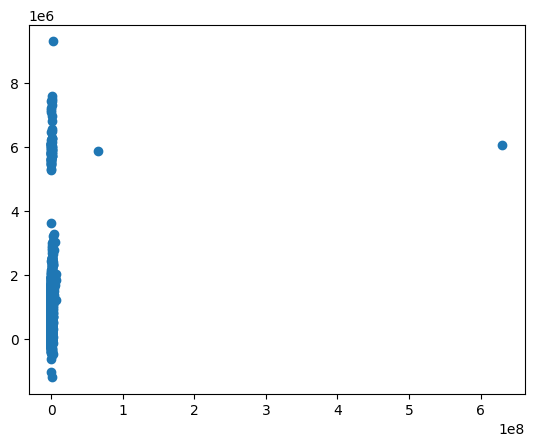

In [14]:
split_index = len(df_train)//2

x_train = x[:split_index, :]
y_train = y[:split_index].ravel()

x_test = x[split_index:, :]
y_test = y[split_index:].ravel()

scale = StandardScaler()

x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)
x_answer = scale.transform(df_test)

linear_regression = LinearRegression()

linear_regression.fit(x_train, y_train)

y_answer_train = linear_regression.predict(x_train)
y_answer_test = linear_regression.predict(x_test)

print('REGRESSOR LINEAR:\nMétrica DENTRO da amostra FORA da amostra')

mse_in = mean_squared_error(y_train, y_answer_train)
rmse_in = sqrt(mse_in)
r2_in = r2_score(y_train, y_answer_train)

mse_out = mean_squared_error(y_test, y_answer_test)
rmse_out = sqrt(mse_out)
r2_out = r2_score(y_test, y_answer_test)

print(' %7s  %17.4f  %15.4f' % ('mse', mse_in, mse_out))
print(' %7s  %17.4f  %15.4f' % ('rmse', rmse_in, rmse_out))
print(' %7s  %17.4f  %15.4f' % ('r2', r2_in, r2_out))

print('REGRESSOR KNN:\nK DENTRO da amostra FORA da amostra')

for k in range(1, x_train.shape[1]+1):
    regressor_knn = KNeighborsRegressor(
        n_neighbors=k,
        weights='distance'
    )

    regressor_knn = regressor_knn.fit(x_train, y_train)

    y_answer_train = regressor_knn.predict(x_train)
    y_answer_test = regressor_knn.predict(x_test)

    mse_in = mean_squared_error(y_train, y_answer_train)
    rmse_in = sqrt(mse_in)
    r2_in = r2_score(y_train, y_answer_train)

    mse_out = mean_squared_error(y_test, y_answer_test)
    rmse_out = sqrt(mse_out)
    r2_out = r2_score(y_test, y_answer_test)
    print(' %3d  %17.4f  %15.4f' % (k, rmse_in, rmse_out))

print(' REGRESSOR POLINOMIAL DE GRAU K:\nK DENTRO da amostra FORA da amostra')

for k in range(1, 6):
    pf = PolynomialFeatures(degree=k)

    pf = pf.fit(x_train)
    x_train_poly = pf.transform(x_train)
    x_test_poly = pf.transform(x_test)
    x_resposta_poly = pf.transform(x_answer)

    regressor_linear = LinearRegression()
    regressor_linear = regressor_linear.fit(x_train_poly, y_train)

    y_answer_train = regressor_linear.predict(x_train_poly)
    y_answer_test = regressor_linear.predict(x_test_poly)

    mse_in = mean_squared_error(y_train, y_answer_train)
    rmse_in = sqrt(mse_in)
    r2_in = r2_score(y_train, y_answer_train)

    mse_out = mean_squared_error(y_test, y_answer_test)
    rmse_out = sqrt(mse_out)
    r2_out = r2_score(y_test, y_answer_test)

    print(' %3d  %17.4f  %15.4f' % (k, rmse_in, rmse_out))

    resposta = regressor_linear.predict(x_resposta_poly)

'''
resposta = regressor_knn.predict(x_resposta)
id = []
for j in range(len(resposta)):
    id.append(str(j))
data = {'id':id,'preco':resposta} 
df = pd.DataFrame(data).to_csv('preco_knn.csv',index=False)
'''
